In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import util

In [6]:
# 二维高斯滤波器，行列不分离
def GaussianFilter(inputImage, sigma):
    timeBegin = cv.getTickCount()
    #输出图像
    outputImage = np.zeros(list(inputImage.shape),dtype='uint8')
    #滤波窗口大小
    windowSize = int(6*sigma-1)

    #获取图像信息
    height, width, channels = inputImage.shape

    center = windowSize // 2  # 将滤波器分为widowSize x windowSize个小方格，中心点为center，坐标为(0, 0)

     #零填充
    border = center#添加边界大小
    transImage = cv.copyMakeBorder(inputImage,border,border,border,border,borderType=cv.BORDER_REPLICATE)

    #生成滤波核
    kernel = np.zeros((windowSize, windowSize), dtype=np.float)# windowSize为奇数
    for i in range(windowSize):
        for j in range(windowSize):
            x = i-center  # 方格的横坐标
            y = center-j  # 方格的纵坐标
            kernel[i, j] = np.exp(-(x**2+y**2)/(2*(sigma**2)))

    kernel /= (2 * np.pi * sigma * sigma)
    kernel /= kernel.sum()
    
    # 平滑操作
    for i in range(height):
        for j in range(width):
            for k in range(channels):
                outputImage[i,j,k] = np.sum(np.multiply(transImage[i:i+windowSize,j:j+windowSize,k], kernel))

    timeEnd = cv.getTickCount()
    time = (timeEnd-timeBegin)/cv.getTickFrequency()
    print("Time of the GaussianFilter  is : ",time)
    return outputImage

In [7]:
# 产生一维高斯滤波器kernel，行列分离
def SepGaussFilter(inputImage,sigma):
    timeBegin = cv.getTickCount()
    #输出图像
    outputImage = np.zeros(list(inputImage.shape),dtype='uint8')
    #滤波窗口大小
    windowSize = int(6*sigma-1) 

    #获取图像信息
    height, width, channels = inputImage.shape
    center = windowSize // 2  # 将滤波器分为widowSize x windowSize个小方格，中心点为center，坐标为(0, 0)

    #零填充
    border = center#添加边界大小
    transImage = cv.copyMakeBorder(inputImage,border,border,border,border,borderType=cv.BORDER_REPLICATE)

    #生成滤波核，其大小为windowSize
    kernel = np.zeros([windowSize], dtype=np.float)
    for i in range(windowSize):
        x = i-center  # 方格的横坐标
        kernel[i] = np.exp(-(x**2)/(2*(sigma**2)))
    kernel /= (2 * np.pi * sigma * sigma)
    kernel /= kernel.sum()

    #行滤波核
    kernelRow = kernel
    #列滤波核
    kernelCol = np.resize(kernel, (windowSize, 1))

    # 开始平滑操作
    # 对行操作
    for j in range(width):
        for k in range(channels):
            transImage[:, j+border, k] = np.sum(np.multiply(transImage[:, j:j+windowSize, k], kernelRow), axis=1) 
    # 对列操作
    for i in range(height):
        for k in range(channels):
            outputImage[i, :, k] = np.sum(np.multiply(transImage[i:i + windowSize, border:width + border, k], kernelCol), axis=0) 

    timeEnd = cv.getTickCount()
    time = (timeEnd-timeBegin)/cv.getTickFrequency()
    print("Time of the SepGaussFilter  is : ",time)
    return outputImage


Time of the GaussianFilter  is :  20.7558481
Time of the SepGaussFilter  is :  0.1422541


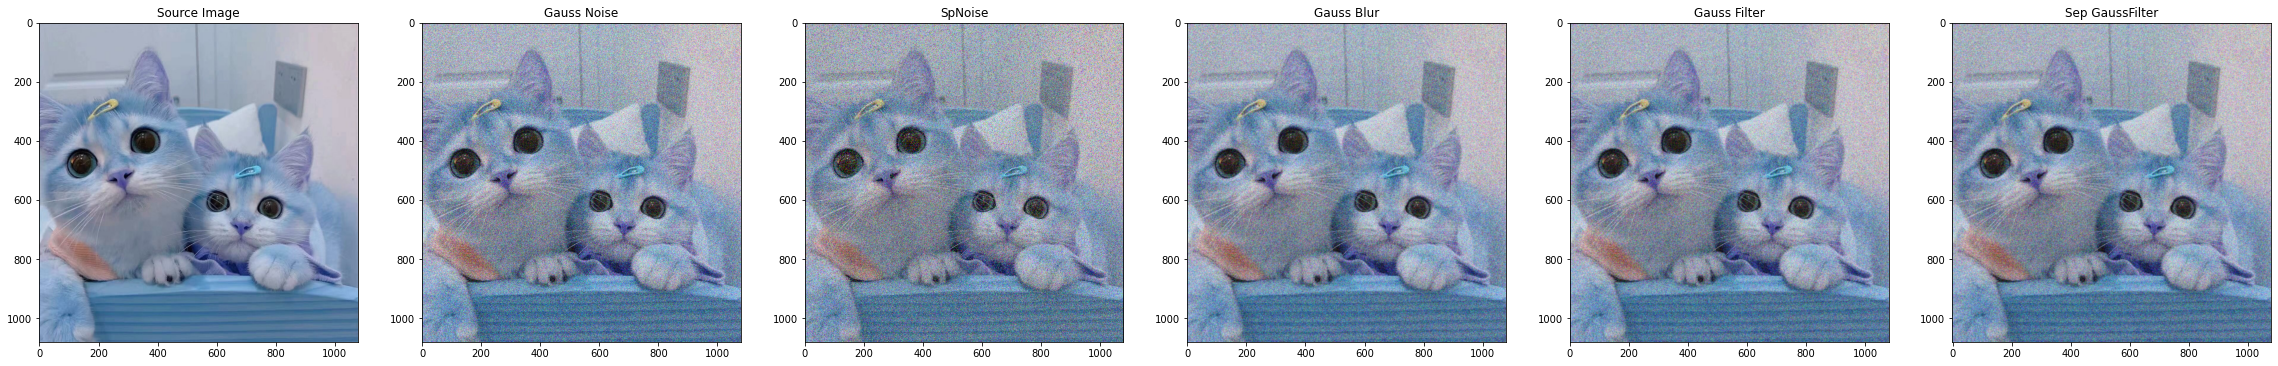

In [8]:
if __name__ == "__main__":
    # 读取图像
    imgSrc = cv.imread("cat.png")

    #产生高斯噪声，处理后图像变为float64格式
    noise_gs_img = util.random_noise(imgSrc, mode="gaussian",mean= 0,var = 0.05)
    #将图像转换为uint8格式，否则保存后是全黑的。
    noise_gs_img = cv.normalize(noise_gs_img, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

    #产生椒盐噪声，处理后图像变为float64格式
    noise_sp_img = util.random_noise(imgSrc, mode="s&p",amount = 0.2)
    noise_sp_img = cv.normalize(noise_sp_img, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

    cv.imwrite("noise_gs.png", noise_gs_img)
    cv.imwrite("noise_sp.png",noise_sp_img)
    #opencv 函数实现高斯滤波
    gs_blur_img  = cv.GaussianBlur(noise_gs_img,(5,5),0.8)
    cv.imwrite("gs_blur.png",gs_blur_img)
    # 高斯滤波
    gs_filter_img = GaussianFilter(noise_gs_img,sigma=0.9)
    cv.imwrite("gs_filter.png", gs_filter_img)
    #行列分离高斯滤波 
    sep_gs_filter_img = SepGaussFilter(noise_gs_img, sigma=0.9)
    cv.imwrite("sep_gs_filter.png", sep_gs_filter_img)
    
    #显示图像
    titles = ["Source Image","Gauss Noise","SpNoise","Gauss Blur","Gauss Filter","Sep GaussFilter"]
    images = [imgSrc,noise_gs_img,noise_sp_img,gs_blur_img,gs_filter_img,sep_gs_filter_img]
    plt.figure(figsize = (40,30))
    for i in range(6):
        plt.subplot(1,6,i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()
